# Datasets creation

In [6]:
import os
from itertools import product

import numpy as np
import pandas as pd
from datasets import load_dataset
from functional import seq
from config import TAGS
from tqdm import tqdm

from map_generation.osm_dataset import TextToImageDataset

# Prepare data

In [7]:
def _flatten_tags(tags):
    tags_flat = (
        seq(tags.items())
        .starmap(lambda k, v: product([k], v if isinstance(v, list) else [v]))
        .flatten()
        .map(lambda x: "_".join(x))
        .list()
    )
    return tags_flat
columns = _flatten_tags(TAGS)
columns[:5]

['aeroway_aerodrome',
 'aeroway_apron',
 'aeroway_gate',
 'aeroway_hangar',
 'aeroway_helipad']

# Saving metadata to image folders
Code creates csv with tags in each city's tiles folder. Metadata.csv is used to generate captions.

Due to changes in srai.SippyMapRegionizer this code does not run with embeddings present in drive. You can skip this step - on drive are folders with created metadata.csv or use freshly created embeddings with previous notebook.

In [8]:
for city in tqdm(os.listdir("../data/tiles")):
    path_to_embedding = f"../data/embeddings_roads/{city}.pkl"
    if os.path.exists(path_to_embedding):
        df = pd.read_pickle(path_to_embedding)
        df = df.reindex(columns=columns, fill_value=0)
        df.index = df.index + ".png"
        df.index = df.index.rename("file_name")
        path = f"../data/tiles/{city}/metadata.csv"
        df.to_csv(path)
    else :
        print(city, "not found")

100%|██████████| 46/46 [00:21<00:00,  2.16it/s]


In [10]:
df = pd.read_pickle(f"../data/embeddings_roads/{city}.pkl")
df = df.reindex(columns=columns, fill_value=0)
df.index = df.index + ".png"
df

,aeroway_aerodrome,aeroway_apron,aeroway_gate,aeroway_hangar,aeroway_helipad,aeroway_holding_position,aeroway_navigationaid,aeroway_parking_position,aeroway_runway,aeroway_taxiway,...,wheelchair_yes,wires_double,wires_single,wood_deciduous,wood_mixed,zone:traffic_BE-VLG:urban,zone:traffic_DE:rural,zone:traffic_DE:urban,zone:traffic_NL:rural,zone:traffic_NL:urban
region_id,,,,,,,,,,,,,,,,,,,,,
11165_26133_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26134_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26135_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26136_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26137_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11257_26162_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11257_26163_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11257_26164_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Get prepared data and push to huggingface hub

In [4]:
ds = TextToImageDataset("../data/tiles/Wroclaw, PL")


None


Resolving data files:   0%|          | 0/4139 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/marcin/.cache/huggingface/datasets/imagefolder/tiles-01a7c0d800e744bb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/marcin/.cache/huggingface/datasets/imagefolder/tiles-01a7c0d800e744bb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-40f9524c6a32b001.arrow


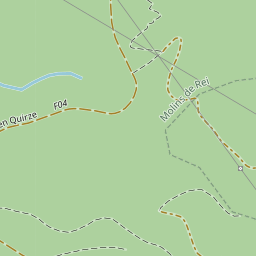

'OSM of area containing: 1 landuse forest  , 1 leisure nature reserve  .'

In [5]:
display(ds[0][0])
ds[0][1]

In [ ]:
hds = ds.to_huggingface_dataset()
hds.push_to_hub("mprzymus/text2tile_small")

In [3]:
large_ds = TextToImageDataset("../data/tiles/").to_huggingface_dataset()
large_ds.push_to_hub("mprzymus/text2tile_large")

Resolving data files: 100%|██████████| 135611/135611 [00:01<00:00, 117838.97it/s]


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1026.76it/s]


Dataset imagefolder downloaded and prepared to /home/marcin/.cache/huggingface/datasets/imagefolder/tiles-bb44cbe6b3b6f93d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
Pushing split train to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 7/7 [09:13<00:00, 79.10s/it]


# Check download works

In [6]:
ds = load_dataset("mprzymus/text2tile")
test_captions = ds["test"]["caption"]

Found cached dataset parquet (/home/marcin/.cache/huggingface/datasets/mprzymus___parquet/mprzymus--text2tile-08c7471b58d60160/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
test_captions[843]

'OSM of area containing: 4 landuse meadows  , 3 landuse farmlands  , 1 natural scrub  , 1 natural water  , 1 water river  .'

In [14]:
test_captions[290]

'OSM of area containing: 2 leisure playgrounds  , 1 shop seafood  , 59 buildings  , 1 shop computer  , 1 office government  .'

In [15]:
test_captions[253]

'OSM of area containing: 2 leisure pitchs  , 191 building apartmentss  , 3 amenity parkings  , 1 amenity fuel  , 2 building industrials  .'

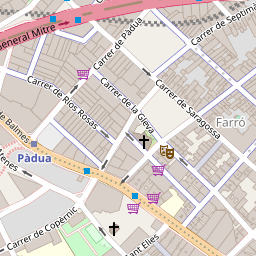

In [16]:
ds["test"]["image"][253]

In [11]:
from map_generation.osm_dataset import create_sentence

df = pd.read_csv("../data/tiles/Amsterdam, Netherlands/metadata.csv")
series = df[df["file_name"] == "33635_21524_16.png"].drop(columns=["file_name"])

create_sentence(series.squeeze(axis=0))

"waterway canal"
"landuse forest"
"highway service"
"shop wholesale"
"place suburb"


'OSM of area containing: 1 waterway canal, 1 landuse forest, 9 highway services , 1 shop wholesale, 1 place suburb.'

TypeError: list indices must be integers or slices, not str